<a href="https://colab.research.google.com/github/bhattacharya5/SpeechUnderstanding/blob/main/MinorProject/M21AIE211_MinorProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2"

/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2


In [ ]:
pip install mutagen

In [ ]:
import os
import torchaudio
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import IPython.display



import time
import zipfile
import mutagen
import mutagen.wave
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

import math
from IPython.display import Audio

##Download LIBRISPEECH dataset

In [ ]:
# Specify the directory where you want the dataset to be downloaded
download_dir = 'LIBRISPEECH'
# Check if the dataset directory exists
if not os.path.exists(download_dir):
    # Create the directory if it does not exist
    os.makedirs(download_dir, exist_ok=True)

    # Choose a dataset from torchaudio.datasets, for example, LibriSpeech
    librispeech_dataset = torchaudio.datasets.LIBRISPEECH(root=download_dir, download=True)
else:
    # Load audio samples from LibriSpeech dataset
    librispeech_dataset = torchaudio.datasets.LIBRISPEECH(root=download_dir, download=False)

### Plot waveform

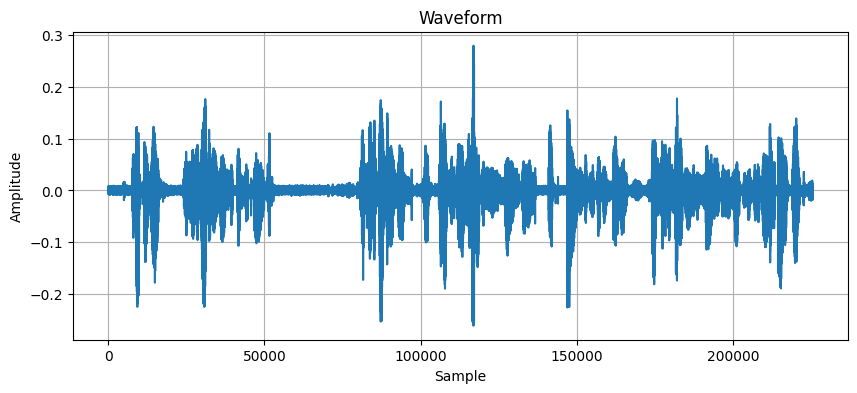

In [ ]:
# Select an index to load a sample from the dataset
index = 0

# Load audio waveform and sample rate for the selected index
waveform, sample_rate, _, _, _, _ = librispeech_dataset[index]

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(waveform.t().numpy())
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.grid(True)
plt.show()

In [ ]:
from IPython.display import Audio
# Play the audio
Audio(data=waveform.numpy(), rate=sample_rate)

###Plot spectogram

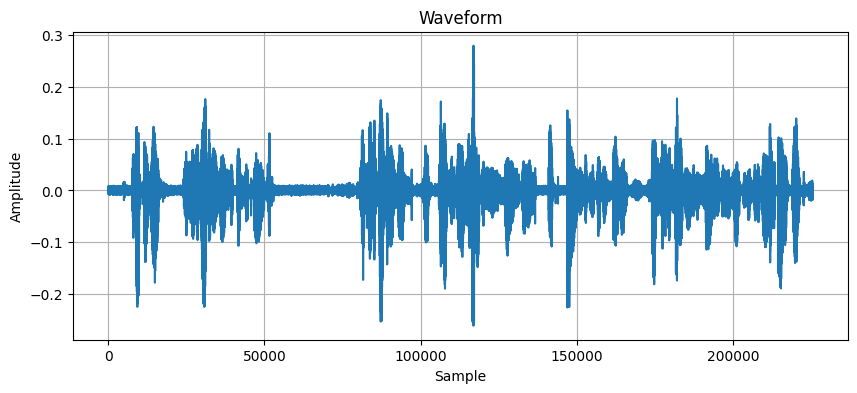

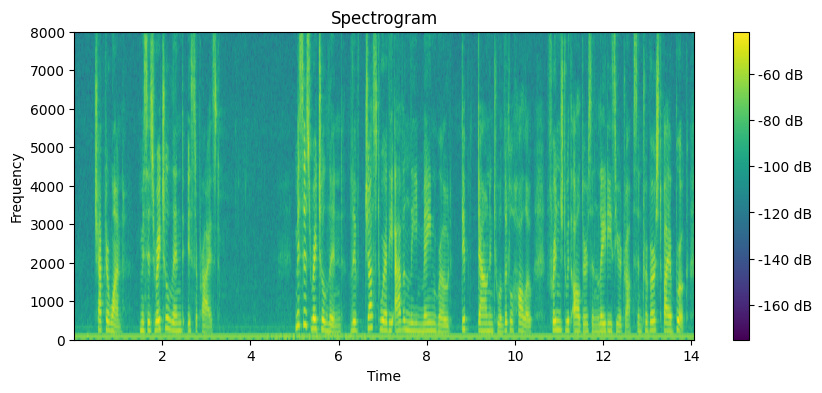

In [ ]:
# Convert waveform to mono if it has more than one channel
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(waveform.t().numpy())
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.grid(True)
plt.show()

# Compute and plot the spectrogram
plt.figure(figsize=(10, 4))
plt.specgram(waveform.squeeze().numpy(), Fs=sample_rate)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

## Download UrbanSound8K

In [ ]:
ls

 LIBRISPEECH/   M21AIE211_MinorProject.ipynb  'Training autoencoder DB norm.ipynb'


In [ ]:
# Specify the directory where you want the dataset to be downloaded
download_dir = 'UrbanSound8K'
# Check if the dataset directory exists
if not os.path.exists(download_dir):
  # Unzip dataset
  !wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
  !tar -xzf urban8k.tgz
  !rm urban8k.tgz

In [ ]:
ls

 LIBRISPEECH/   M21AIE211_MinorProject.ipynb  'Training autoencoder DB norm.ipynb'   UrbanSound8K/


In [ ]:
!cat UrbanSound8K/UrbanSound8K_README.txt

UrbanSound8K

Created By
----------

Justin Salamon*^, Christopher Jacoby* and Juan Pablo Bello*
* Music and Audio Research Lab (MARL), New York University, USA
^ Center for Urban Science and Progress (CUSP), New York University, USA
http://serv.cusp.nyu.edu/projects/urbansounddataset
http://marl.smusic.nyu.edu/
http://cusp.nyu.edu/

Version 1.0


Description
-----------

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, 
children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The classes are 
drawn from the urban sound taxonomy described in the following article, which also includes a detailed description of 
the dataset and how it was compiled:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

All excerpts are taken from field recordings uploaded to www.freesou

In [ ]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [ ]:
dataset_df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav


In [ ]:
dataset_df = dataset_df.drop(columns=['fold', 'slice_file_name', 'fsID', 'start', 'end'])

In [ ]:
# Randomly select one sample of each class
random_samples = dataset_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

In [ ]:
# Listen to the recordings (index can be changed to listen to a different recording)
index = 0
print('Listen to {} sample'.format(labels[index]))
IPython.display.Audio(audio_samples[index])

Listen to air_conditioner sample


###Plot waveform

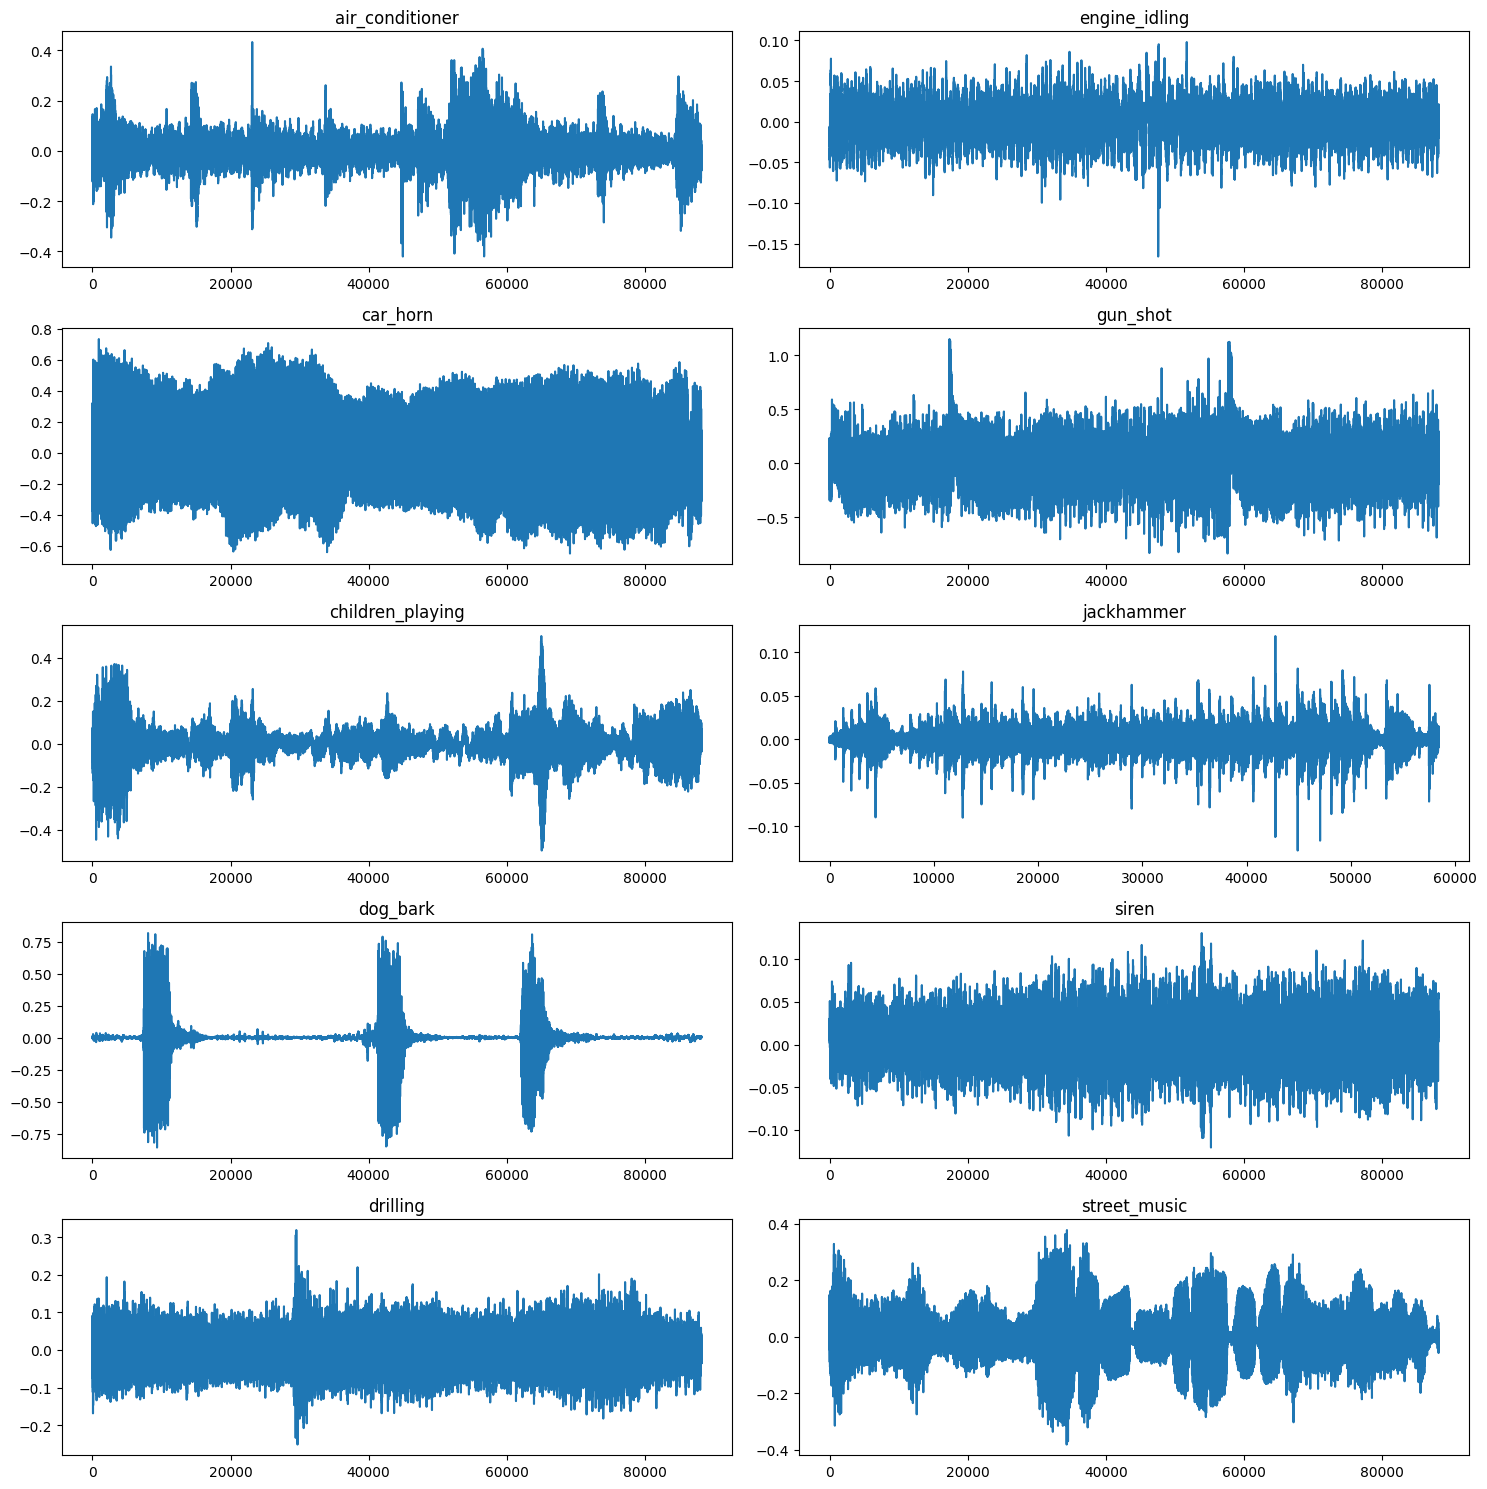

In [ ]:
# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        axs[row][col].plot(audio_file)
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()


###Plot Spectogram

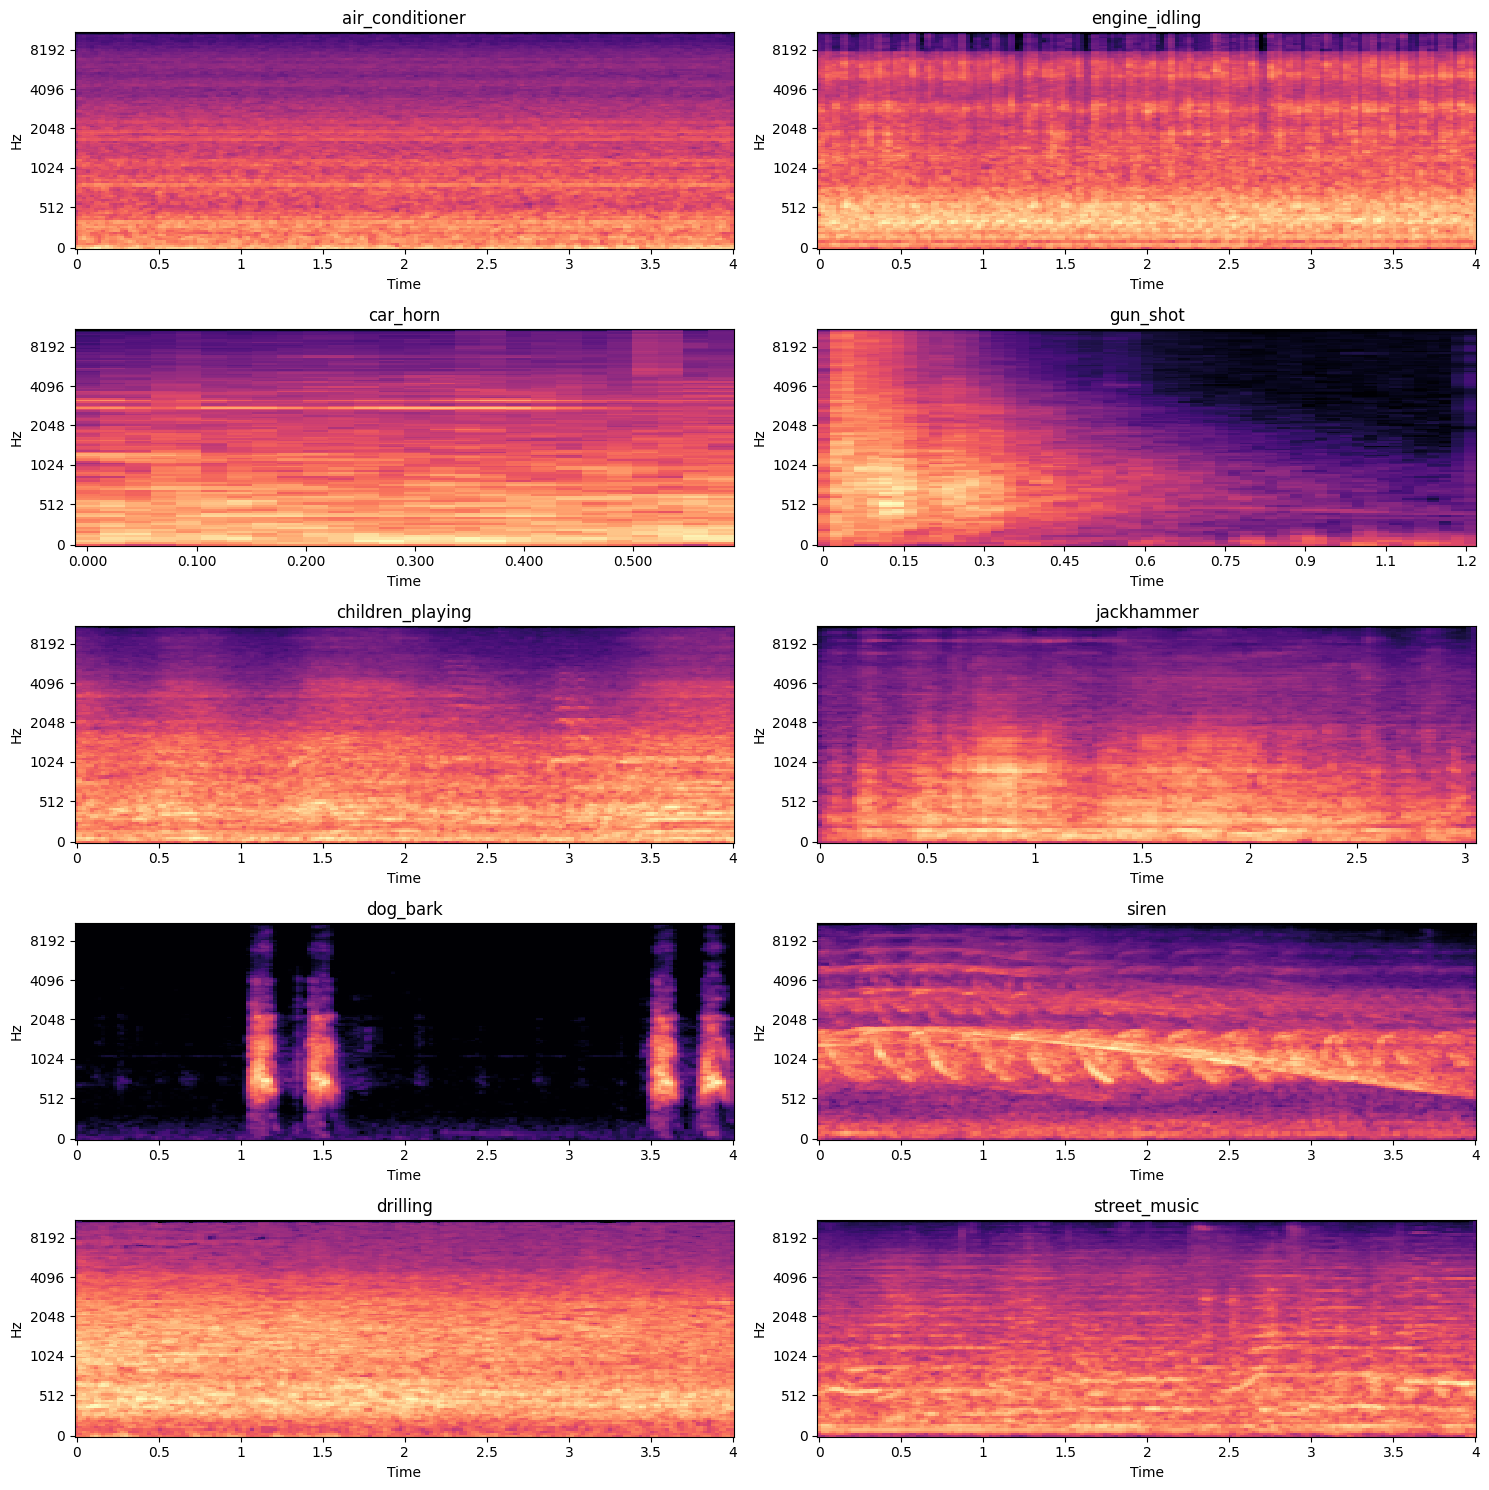

In [ ]:
# Visualize the spectrograms
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        spectrogram = librosa.feature.melspectrogram(y=audio_file, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sample_rate, ax=axs[row][col], x_axis='time', y_axis='mel')
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()


##Mix combine UrbanSound8K and LIBRISPEECH

In [25]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2"

/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2


In [26]:
import torchaudio
import numpy as np
import math


# Select the number of samples to mix
num_mix_samples = 10
# Select the number of random samples from UrbanSound to mix with each LibriSpeech sample
num_random_samples_to_mix = 3
# Define the duration of each sample in seconds
sample_duration = 1  # 5 seconds

# Randomly select one sample of each class from UrbanSound
random_samples = dataset_df.groupby('class').sample(1)
random_samples_paths, random_samples_labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Calculate the number of frames for the given duration
sample_rate = librispeech_dataset[0][1]
num_frames = int(sample_rate * sample_duration)

# Select the index of the mixed audio file to save and listen to
index_to_save = 0

# Iterate over the LibriSpeech samples
for index in range(num_mix_samples):
    # Load audio waveform and sample rate for the selected index from LibriSpeech dataset
    librispeech_waveform, librispeech_sample_rate, _, _, _, _ = librispeech_dataset[index]

    # Trim the LibriSpeech waveform to the desired duration
    librispeech_waveform = librispeech_waveform[:, :num_frames]

    # Mix with random samples from UrbanSound
    mixed_waveform = librispeech_waveform.numpy().copy().flatten()  # Flatten to ensure one-dimensional array
    for _ in range(num_random_samples_to_mix):
        random_sample_path = np.random.choice(random_samples_paths)
        random_sample_waveform, random_sample_rate = torchaudio.load(random_sample_path)

        # Resample the random sample waveform to match the sample rate of LibriSpeech
        random_sample_waveform = torchaudio.transforms.Resample(orig_freq=random_sample_rate, new_freq=librispeech_sample_rate)(random_sample_waveform)
        random_sample_waveform = random_sample_waveform[:, :num_frames]

        # Resize the random sample waveform to match the shape of the LibriSpeech waveform
        random_sample_waveform = torchaudio.transforms.Resample(orig_freq=random_sample_waveform.shape[1], new_freq=librispeech_waveform.shape[1])(random_sample_waveform)

        # Flatten to ensure one-dimensional array
        random_sample_waveform = random_sample_waveform.numpy().flatten()

        # Ensure that both waveforms have the same length
        min_length = min(len(mixed_waveform), len(random_sample_waveform))
        mixed_waveform = mixed_waveform[:min_length]
        random_sample_waveform = random_sample_waveform[:min_length]

        mixed_waveform += random_sample_waveform

    # Save the mixed audio to a .npy file
    if index == index_to_save:
        np.save(f'mixed_audio_{index_to_save}.npy', mixed_waveform)

# Load the mixed audio file
loaded_mixed_waveform = np.load(f'mixed_audio_{index_to_save}.npy')

# Play the audio using IPython.display.Audio
print(f"Playing mixed audio file {index_to_save}:")
Audio(data=loaded_mixed_waveform, rate=sample_rate)


Playing mixed audio file 0:


### Following is the code to convert mixed and original audio to spectogram

In [ ]:
import torchaudio
import numpy as np
import torch

# Select the number of samples to mix
num_mix_samples = 50
# Select the number of random samples from UrbanSound to mix with each LibriSpeech sample
num_random_samples_to_mix = 3
# Define the duration of each sample in seconds
sample_duration = 2  # 1 second

# Randomly select one sample of each class from UrbanSound
random_samples = dataset_df.groupby('class').sample(1)
random_samples_paths, random_samples_labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Calculate the number of frames for the given duration
sample_rate = librispeech_dataset[0][1]
num_frames = int(sample_rate * sample_duration)

# Iterate over the LibriSpeech samples
for index in range(num_mix_samples):
    # Load audio waveform and sample rate for the selected index from LibriSpeech dataset
    librispeech_waveform, librispeech_sample_rate, _, _, _, _ = librispeech_dataset[index]

    # Trim the LibriSpeech waveform to the desired duration
    librispeech_waveform = librispeech_waveform[:, :num_frames]

    # Compute the spectrogram using Short-Time Fourier Transform (STFT)
    specgram = torchaudio.transforms.Spectrogram()(librispeech_waveform)

    # Convert the spectrogram to a numpy array
    specgram_np = specgram.numpy()

    # Save the spectrogram numpy array as a .npy file
    np.save(f'librispeech_specgram_{index}.npy', specgram_np)

    # Mix with random samples from UrbanSound
    mixed_waveform = librispeech_waveform.numpy().copy().flatten()  # Flatten to ensure one-dimensional array
    for j_index in range(num_random_samples_to_mix):
        random_sample_path = np.random.choice(random_samples_paths)
        random_sample_waveform, random_sample_rate = torchaudio.load(random_sample_path)

        # Resample the random sample waveform to match the sample rate of LibriSpeech
        random_sample_waveform = torchaudio.transforms.Resample(orig_freq=random_sample_rate, new_freq=librispeech_sample_rate)(random_sample_waveform)
        random_sample_waveform = random_sample_waveform[:, :num_frames]

        # Resize the random sample waveform to match the shape of the LibriSpeech waveform
        random_sample_waveform = torchaudio.transforms.Resample(orig_freq=random_sample_waveform.shape[1], new_freq=librispeech_waveform.shape[1])(random_sample_waveform)

        # Flatten to ensure one-dimensional array
        random_sample_waveform = random_sample_waveform.numpy().flatten()

        # Ensure that both waveforms have the same length
        min_length = min(len(mixed_waveform), len(random_sample_waveform))
        mixed_waveform = mixed_waveform[:min_length]
        random_sample_waveform = random_sample_waveform[:min_length]

        mixed_waveform += random_sample_waveform

    # Compute the spectrogram of the mixed waveform
    mixed_specgram = torchaudio.transforms.Spectrogram()(torch.tensor(mixed_waveform))

    # Convert the spectrogram to a numpy array
    mixed_specgram_np = mixed_specgram.numpy()

    # Save the spectrogram numpy array as a .npy file
    np.save(f'librispeech_specgram_{index}_mixed_specgram.npy', mixed_specgram_np)


In [ ]:
index_to_save = 2

# Load the mixed audio file
loaded_mixed_waveform = np.load(f'librispeech_specgram_{index_to_save}_mixed_specgram.npy')
sample_rate = librispeech_dataset[0][1]
# Play the audio using IPython.display.Audio
print(f"Playing mixed audio file {index_to_save}:")
print(sample_rate)
Audio(data=loaded_mixed_waveform, rate=sample_rate)

Playing mixed audio file 2:
16000


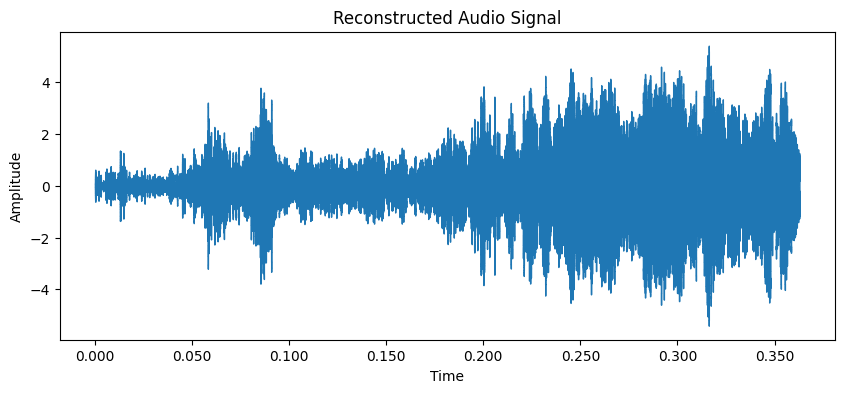

In [ ]:

index_to_save = 2


import soundfile as sf
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load the spectrogram from the .npy file
spectrogram = np.load(f'librispeech_specgram_{index_to_save}_mixed_specgram.npy')

# Reconstruct the audio signal from the spectrogram
audio_signal = librosa.griffinlim(spectrogram)

# Save the reconstructed audio as a .wav file
sf.write('reconstructed_audio.wav', audio_signal, samplerate=44100)

# Visualize the reconstructed audio
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio_signal, sr=44100)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Reconstructed Audio Signal')
plt.show()


In [ ]:
Audio(data="reconstructed_audio.wav", rate=sample_rate)